# IMA 208 TP5: homography estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In this practical work, we will study how to estimate an homography between two given images. We will consider both the simple DLT algorithm (part I) and the RANSAC algorithm (part II).

To reduce the time you need for this practical work, we will use a few pre-implemented functions of openCV. Make sure that your library installation is correct before starting to work.

# Part 1: homography estimation from hand-selected keypoints: DLT algorithm

We assume that we have an image of a documents suffering from severe perspective distortion. The objective of this part is to warp this image (denoted in the following as img2) to remove the distortion using a reference image beeing in the desired pose (denoted as img1).

The following cell enables to vizualize the images using openCV.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x22dee4f3980>)

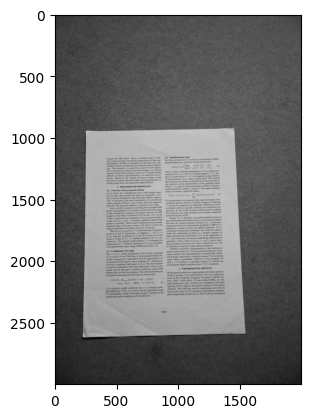

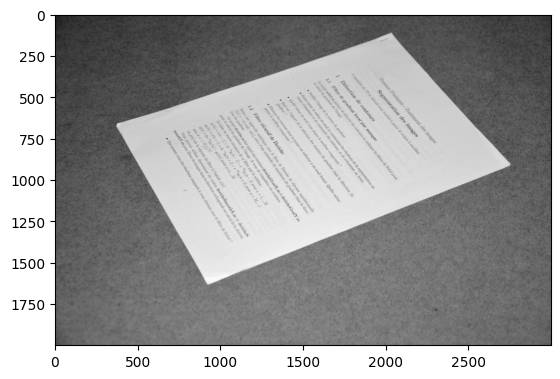

In [2]:
img1 = cv2.cvtColor(cv2.imread('Feuille_redressee.jpg'),cv2.COLOR_BGR2GRAY) # Reference image
img2 = cv2.cvtColor(cv2.imread('Feuille.jpg'),cv2.COLOR_BGR2GRAY) # Image to be processed

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To correct the homography beetween the to images, we will need some points to match between the two images.

**Question:** how many points do you at least need to estimate the homography? Why?

**Answer:**

We need at least 4 points to estimate the homography. Indeed there are 8 dof  for estimating a single homography between two images and each point has 2 dof.

However, due to noise on the image we might need to use more points.

**Implementation:** to estimate the homography, some matching keypoints between the reference image and the to-be-porcessed one are given below. They here correspond to the corners of the two documents.

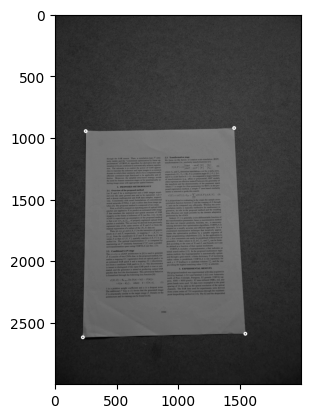

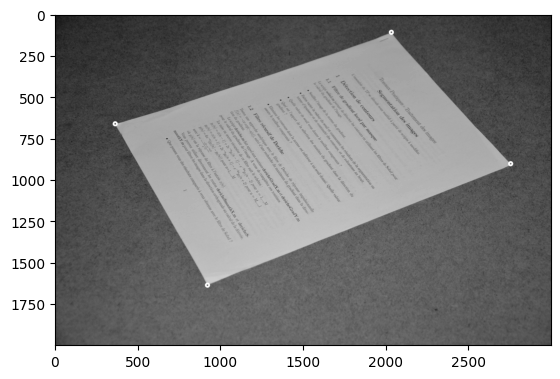

In [3]:
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]] # Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts2 = [[2030,110],[2750,904],[920,1638],[363,663]] # Keypoints for img2,  keep the same order of the points as pts1.

# Below, we convert the points you found above into cv2 points object for vizualization (no need to change anything)
kp1 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts1]
kp2 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts2]

for i in range(len(pts1)):
    img1c=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c,cmap='gray')

for i in range(len(pts2)):
    img2c=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points

**Visualize** the keypoints you found above to check that they are properly assigned.

Now, we will start implementing the DLT.

**Question:** recall what the DLT is. Give a pseudo code. What are its potential flaws and strengths?

**Answer**

DLT (Direct Linear transform) is a simple algorithm for homography estimation.

**Pseudo Code**
- input: 2D to 2D points correspondances $x_i$ <-> $x'_i$

Mandatory Normalization
- Normalization of x: x <- Tx with T a similarity transformation computed to apply a translation and a scaling to center x and have the average distance from the origin set to $\sqrt{2}$
- Normalization of x': x <- T'x' 

Simplistic DLT steps
- for each correspondence $x_i$ <-> $x'_i$ compute the matrice $A_i$ ( expression in the lesson)
- assemble the n 2x9 matrices $A_i$ into a single 2n x 9 matrix $A$
- Compute the SVD decompostion of A: A = $UDV^T$ 
- get h: h is the last column of V
- Determine H from h (the first 3 coordinates of h constitue the first row of H, etc...)

Denormalisation:
- H = $T'^{-1}HT$

Strenghth and flaws:

The DLT algorithm is quite simple.The issue is that point mismatch strongly disturbs the DLT algorithm: it is not robust to outliers.



The first step of the DLT algorithm is to normalize the image point.

**Question:** Recall why the normalization is important. Recall how to do it.

**Answer:**

The normalization is important because without it the Ai matrix is ill conditionned, can't be "inverted" and the solution h can't be computed.

To do the normalization, we need to compute a transformation matrix so that by applying it to the points:
- Points are **translated** to have their centroids at $(0,0,0)^T$
- Points are **scaled** to have the average distance to the origin equal to $\sqrt{2}$

A different similarity transformation matrix T must be computed for each image.



In the following, we will perform the normalization using the so called *homogeneous* coordinates of the keypoints. The main idea is to add a last coordinate equal to one for each point. The point (x,y) thus becomes (x,y,1) in homogeneous coordinate.

The advantage is that we will be able to do the normalization using a simple matrix product : X_norm = T@X.

**Fill** the blanks in the below implementation.

In [4]:
def normalize_image_points(imageEucl):
    """
    Input: 2D list with x,y image points
    Output: normalized data points
    """

    print("Normalizing data using similarity matrix...")
    imageEucl=np.array(imageEucl)

    mean, std = np.mean(imageEucl, axis=1), np.std(imageEucl, axis=1) #modif # To be filled, (elementwise) mean and std of the data points
    print(np.shape(imageEucl))
    image = np.zeros((3, 4)) # Image in homogeneous coordinate
    image[0:2,:] = imageEucl
    image[2,:]=1 # modif
    
    # Define a similarity matrix enabling to normalize the data. Write the cooefficients in Tranformation such that image_norm = image@Transformation
    sx = np.sqrt(2)/std[0]  #modif
    sy = np.sqrt(2)/std[1]  #modif
    Transformation = np.array([[1/sx, 0, mean[0]],
                               [0, 1/sy, mean[1]],
                               [0, 0, 1]]) #modif
    Transformation = np.linalg.inv(Transformation)

    # Apply transformation on data points
    image_norm = Transformation@image
    
    # Retrieve normalized image in the original input shape (25, 2)
    image_norm = image_norm[0:2,:]

    return image_norm, Transformation




**Question:** Verify that your data looks properly normalized.

**Answer**
After the normalization the average point should be equal to $(0,0,0)^T$ which is indeed the case here.

In [5]:
normalize_image_points(np.array(pts1))

Normalizing data using similarity matrix...
(2, 4)


(array([[-1.38645288,  1.31017554,  1.5143296 , -1.43805226],
        [-1.39285967, -1.43519583,  1.38947278,  1.43858272]]),
 array([[ 2.24345127e-03,  0.00000000e+00, -1.94282880e+00],
        [ 0.00000000e+00,  1.69344641e-03, -2.99994031e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

The second step is to compute the A matrix from the normalized data points.

**Fill** the blanks in the function below.

**Question:** justify the shape of the A matrix.

**Answer:**

The last row of each Ai matrix (size 3 x 9)  can be obtained by a linear combination of the two 1st ligns so it doesn't bring any new information: we can remove it since it is useless.
The Ai matrixs therefore have a size 2 x 9

The A matrix is obtained by combining all Ai matrixs and therefore has a 2*4 x 9 ie 8 x 9 size.

In [6]:
def compute_matrix_A(points1, points2, no_points):
    """
    Input: Already normalized correspondences for image1 and image2
    Output: Matrix A as defined in Zisserman p. 91
    """

    A = []

    for i in range(0, no_points):
        x, y = points1[0, i], points1[1, i] # Denote the coordinate in image 1 x and y for shortcut
        x_prime, y_prime = points2[0, i], points2[1, i] # Denote the coordinate in image 2 x_prime and y_prime for shortcut

        # Create A_i according to the fomula given in class
        # here we are assuming w_i and w_i_prime are one
        A.append([0, 0, 0, -x, -y, -1, y_prime*x, y_prime*y, y_prime])
        A.append([x, y, 1, 0, 0, 0, -x_prime*x, -x_prime*y, -x_prime])
    print()
    print("Stacked matrix A shape:", np.shape(A))

    return np.asarray(A)



We are now ready to code the whole homography computation function. 

**Fill** the gaps below.

In [7]:
def compute_homography(pts1,pts2):

    # Set data points to numpy arrays
    no_points = pts1.shape[1] # Number of points

    # Normalize the data
    image1_normalized, T = normalize_image_points(pts1) #modif
    image2_normalized, T_prime = normalize_image_points(pts2) #modif
    
    # Get matrix A
    # A = ...
    A = compute_matrix_A(image1_normalized, image2_normalized, no_points)

    # Compute SVD of A
    U, S, V = np.linalg.svd(A) #modif
    V = V.T # So that A = USV.T
    
    # Get last column of V (this is the vector h)
    h = V[:,-1] #modif
    
    # Obtain homography by reshaping h (H tilde)
    print()
    print("Reshaping to get homography H_tilde...")
    H_tilde = h.reshape(3,3) #modif

    # Denormalize to obtain homography (H) using the transformations and generalized pseudo-inverse
    H = np.linalg.inv(T_prime)@H_tilde@T #modif

    print()
    print("Denormalized to obtain homography H for 2D data points...")
    print("Matrix H:")
    print(H)
    
    return H

**Question:** Apply the compute_homography function to warp the document image 2 into the perspective of document 1. Any comment ?

**Answer**
It works well, the paper document on image 2 is in the same perspective of the one on image 1 after applying the compute_homography function.

We can notice some strange results on the corners of the image.

Normalizing data using similarity matrix...
(2, 4)
Normalizing data using similarity matrix...
(2, 4)

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.89710151e-01 -6.17873517e-01  1.79973010e+03]
 [ 3.58788747e-01  2.07651631e-01 -2.17742589e+02]
 [-6.16844041e-05 -4.82980480e-06  6.40775923e-01]]


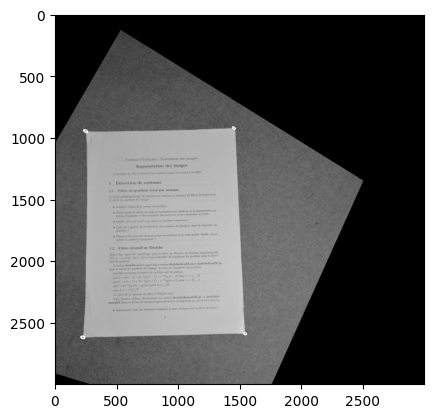

In [8]:
H = compute_homography(pts1,pts2)
homography_matrix_normalized = H/ H[2,2]
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

**Answer:**

**Question:** test the sensitivity of the above algorithm to errors in the matching keypoints. Are you able to obtain good results if you have a false match?

Answer to the same question is you have more matching points than the corners.

**Answer:**

The results obtained with one false match are not good at all. We get a completely false result.

Normalizing data using similarity matrix...
(2, 4)
Normalizing data using similarity matrix...
(2, 4)

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 8.49695353e-02 -1.95498065e-01  8.17047983e+02]
 [ 1.54527551e-01  3.12864586e-01 -2.63446120e+02]
 [-3.10231215e-04  1.38868687e-04  5.97743721e-01]]


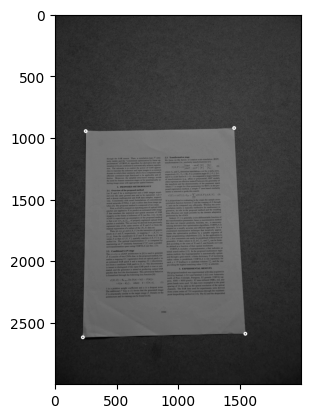

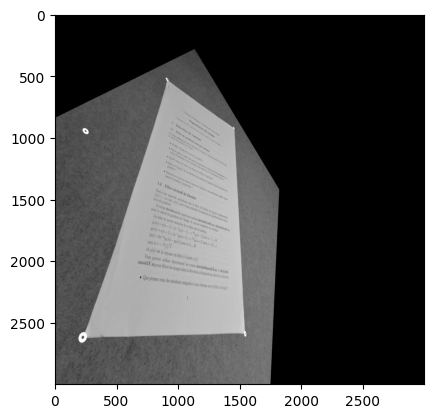

In [9]:
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]] # Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts2 = [[1000,110],[2750,904],[920,1638],[363,663]] # Keypoints for img2,  keep the same order of the points as pts1.

for i in range(len(pts1)):
    img1c_dec=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c_dec,cmap='gray')

for i in range(len(pts2)):
    img2c_dec=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c_dec,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points

H = compute_homography(pts1,pts2)
homography_matrix_normalized = H / H[2, 2]
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

# Part 2: automatic homography estimation and panorama stitching

To bypass the flaws that we observed with the previous method, we now propose to use a robust homography estimation method, the RANSAC algorithm. As an application, we will consider panorama stitching: from two given overlapping images, create a single one which is a panorama. To do that, we will need to estimate the best homography to warp an image into the perspective of the other. In addition, to avoid the cumbersome choice of the matching points between the two images, we will do an automatic keypoint identification by using the SIFT features.

Let us first load the two considered images.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x22df62504d0>)

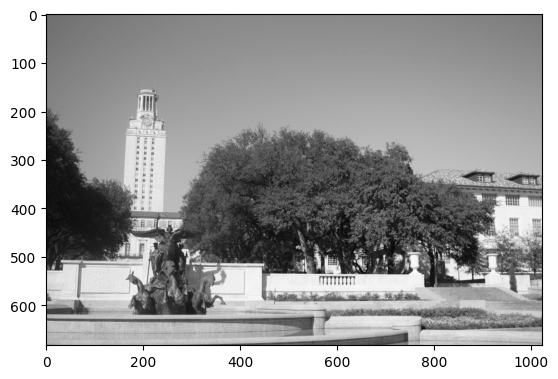

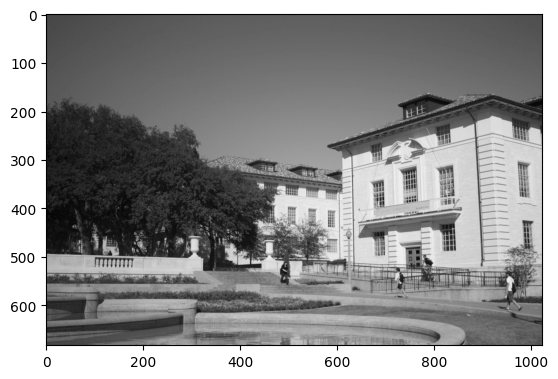

In [10]:
img1c = cv2.cvtColor(cv2.imread('uttower_left.jpg'),cv2.COLOR_BGR2GRAY)
img2c = cv2.cvtColor(cv2.imread('uttower_right.jpg'),cv2.COLOR_BGR2GRAY)

img1 = img1c
img2 = img2c

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To stitch the two images, we need to have access to pair of corresponding points between image 1 and image 2. To do that, we first need to extract some keypoints in both images (that will be matched later on). We will use here the SIFT descriptors.

**Implement** the SIFT descriptors for both image 1 and image 2. You might be willing to use the cv2.SIFT_create and sift.detectAndCompute.

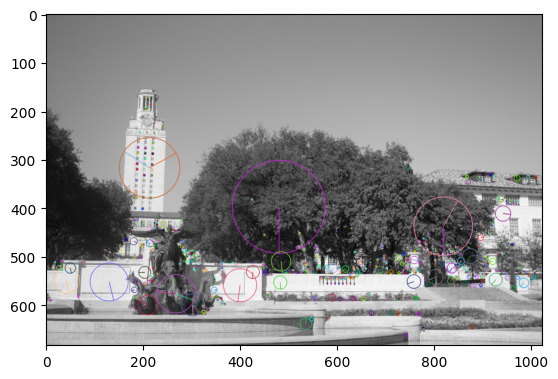

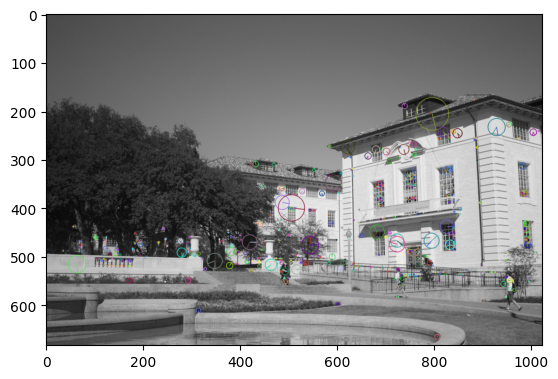

In [11]:
sift = cv2.SIFT_create(contrastThreshold=0.13) # Creates an object of the SIFT class. The larger the threshold, the smaller the number of points
kp1,desc1 = sift.detectAndCompute(img1, None) #kp1 = location of the keypoints, desc1 = corresponding descriptors.

# For visualization
img1c=cv2.drawKeypoints(img1,kp1,img1c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1c)
plt.show()

kp2,desc2 = sift.detectAndCompute(img2, None) #kp2 = location of the keypoints, desc2 = corresponding descriptors.
img2c=cv2.drawKeypoints(img2,kp2,img2c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2c)

**Question:** explain the shapes of desc1, kp1 and desc2, kp2 and their respective roles.

**Answer:**

- **kp1, kp2**: The shape of kp1 is N*m where N is the number of keypoints detected. Indeed kp1 contains the location (x,y) of each keypoint detected and other informations about it. 

- **desc1, desc2**: The shape of desc1 is the N*128 where N is the number of keypoints detected and 128 is the size of the SIFT descriptor for each point (ie feature vectors that describe the local appearance around each keypoint). It stores numerical representations of the local patches around the keypoints, which will be used to proceed to the feature matching between the two images

Now that we have obtained the SIFT descriptor, we have to match them.

**Complete** the following code.

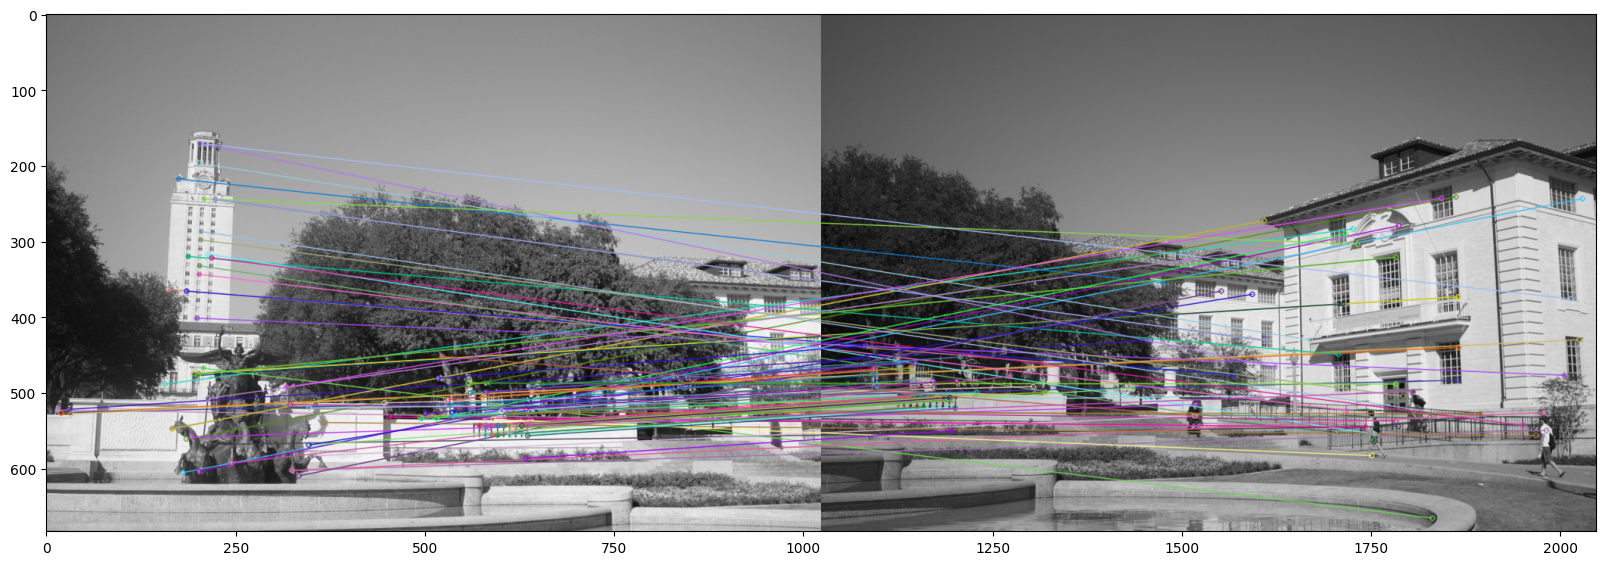

(<Figure size 2000x1200 with 1 Axes>,
 None)

In [12]:
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(desc1,desc2) 


# For visualizing the matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], img2, flags=2)
plt.figure(figsize=(20,12)),plt.imshow(img3),plt.show()

**Question:** comment the match quality. Do you think that the previous matching would enable a decent homography computation using the DLT algorithm of the first part?

**Answer:**

The match quality is quite poor, as there are many mismatched points. For example, some points from the top of the tower in image 1 are incorrectly matched with points in image 2, even though the tower is not visible in that image.

This incorrect matching would prevent a reliable homography computation using the DLT algorithm, as we observed that even a single pair of mismatched points can lead to significantly poor results.

The following code enables to keep only the coordinates of the 100 best matches in the two images. We will use them as an input of a RANSAC, which will enable to do a robust homography estimation between the two images.

In [13]:
matches = sorted(matches, key=lambda x: x.distance) # Sort the matches based on distance. The smaller the distance, the better the match.


D1 = np.ones((2,100)) # Coordinates in image 1 of the first best matching points
D2 = np.ones((2,100)) # Coordinates in image 2 of the first best matching points
for ii in range(100):
    D1[:,ii] = kp1[matches[ii].queryIdx].pt
    D2[:,ii] = kp2[matches[ii].trainIdx].pt

D1 = D1.astype(int)
D2 = D2.astype(int)

In [14]:
print(D1.shape)

(2, 100)


Now, we are ready to code the RANSAC algorithm.

**Fill** the gaps in the code below.

In [15]:
def ransac(D1, D2, num, threshold, iterations):
    # D1, D2 : matched points between the two images
    # num : number of points to compute the homography
    # threshold : distance threshold for determining if a pair of point in an inlier or an outlier
    # iterations : number of iterations / number of sampling
    
    D1h =  np.ones((3,D1.shape[1])) #correspond to D1 transformed into homogeneous coordinates
    D1h[0:2,:] = D1
    
    D2h = np.ones((3,D2.shape[1])) #D2h correspond to D2 transformed into homogeneous coordinates
    D2h[0:2,:] = D2
        
    n = D1.shape[1] # Number of points in D1
    

    best_n_inlier = 0
    best_H = np.zeros((3,3)) # Best homography matrix. Fill the gap with a matrix of the right size full of 0.
    
    #point1 = np.zeros((2,1)) 
    #point2 = np.zeros((2,1)) 
    #in_res = np.zeros((1,1)) 
    for i in range(iterations):
        s = np.random.choice(n, 4, replace=False)  # Draw 4 unique random indices # Draw randomly 4 indices to extract 4 points among D1 and D2. You can use np.random.choice()
        
        pts1 =  D1[:, s] #pts1 is the chosen points among D1
        pts2 =  D2[:, s] #pts2 is the chosen points among D2
        
        H = compute_homography(pts1,pts2)# Compute the corresponding homography. You can reuse the function of part I.
        
        D2_new = np.dot(H, D1h) # Transform the points of D1h to be able to compare them to the ones of D2h
        
        # Normalize D2_new
        D2_new[0, :] = np.divide(D2_new[0, :],D2_new[2, :])
        D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])
        D2_new[2, :] = np.divide(D2_new[2, :],D2_new[2, :])
        
        
        
        SD = np.sqrt(np.sum((D2h - D2_new)**2, axis=0)) # Compute the distance between D2_new and D2h
        
        inliers = SD < threshold # Compute the inliers
        num_inlier = np.sum(inliers)# Compute the number of inliers
        
        if num_inlier > best_n_inlier: # If you obtained the best result, store the corresponding homography
            best_H = H
            best_n_inlier = num_inlier
            point1 = D1[:2, inliers]
            point2 = D2[:2, inliers]
            in_res = SD[inliers]
    
    
    return best_H, best_n_inlier, point1, point2, in_res

Using the function you implemented above, **launch the RANSAC algorithm** to estimate the homography between the two images.

In [16]:
threshold = 1;
num = 4;
iterations = 1000;
[H, inliers, point1, point2, residue] = ransac(D1, D2, num,threshold, iterations)

Normalizing data using similarity matrix...
(2, 4)
Normalizing data using similarity matrix...
(2, 4)

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 6.23957447e-01  2.64611672e-01 -4.37941292e+02]
 [ 8.78737681e-02  7.99990493e-01 -2.02414799e+02]
 [ 1.52134304e-04  5.93868304e-04  1.48337874e-01]]
Normalizing data using similarity matrix...
(2, 4)
Normalizing data using similarity matrix...
(2, 4)

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-2.25609717e+00 -1.58301118e+00  2.74652967e+03]
 [-3.00726191e+00 -1.19772506e+00  3.20052930e+03]
 [-7.15390459e-03 -4.04783936e-03  8.17507010e+00]]
Normalizing data using similarity matrix...
(2, 4)
Normalizing data using similarity matrix...
(2, 4)

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homograp

C:\Users\manel\AppData\Local\Temp\ipykernel_12196\1703243501.py:33: RuntimeWarning: invalid value encountered in divide
  D2_new[0, :] = np.divide(D2_new[0, :],D2_new[2, :])
C:\Users\manel\AppData\Local\Temp\ipykernel_12196\1703243501.py:34: RuntimeWarning: divide by zero encountered in divide
  D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])
C:\Users\manel\AppData\Local\Temp\ipykernel_12196\1703243501.py:34: RuntimeWarning: invalid value encountered in divide
  D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])
C:\Users\manel\AppData\Local\Temp\ipykernel_12196\1703243501.py:35: RuntimeWarning: invalid value encountered in divide
  D2_new[2, :] = np.divide(D2_new[2, :],D2_new[2, :])


Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 5.63047752e-01 -2.15380104e-02 -2.37981626e+02]
 [ 3.78907742e-02  5.74358705e-01 -4.62367263e+01]
 [ 5.21053957e-05  4.11051294e-05  5.16812026e-01]]
Normalizing data using similarity matrix...
(2, 4)
Normalizing data using similarity matrix...
(2, 4)

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 5.90321484e-01  4.78091118e-02 -2.97826491e+02]
 [ 6.21597352e-02  6.23034004e-01 -9.24191861e+01]
 [ 9.24541468e-05  1.70180638e-04  4.14945030e-01]]
Normalizing data using similarity matrix...
(2, 4)
Normalizing data using similarity matrix...
(2, 4)

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 6.07334285e-01 -2.47732931e-02 -2.75604020e+02]
 [ 8.53649962e-02  5.74485596e-01 -8.83316299e+

C:\Users\manel\AppData\Local\Temp\ipykernel_12196\1703243501.py:33: RuntimeWarning: divide by zero encountered in divide
  D2_new[0, :] = np.divide(D2_new[0, :],D2_new[2, :])


Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 6.28737859e-01  1.59017452e-01 -3.82562687e+02]
 [ 9.55589761e-02  7.14323638e-01 -1.60779093e+02]
 [ 1.61766599e-04  3.95698680e-04  2.51685394e-01]]
Normalizing data using similarity matrix...
(2, 4)
Normalizing data using similarity matrix...
(2, 4)

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-5.07309191e-01  2.32641870e-01  8.93569086e+01]
 [ 4.29636845e-02 -3.39479957e-01 -1.33452154e+02]
 [ 1.06541106e-04  4.47354934e-04 -8.84483959e-01]]
Normalizing data using similarity matrix...
(2, 4)
Normalizing data using similarity matrix...
(2, 4)

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 6.15090571e-01  2.30320203e-02 -3.04938424e+02]
 [ 8.82291061e-02  6.09272693e-01 -1.06469211e+

In [17]:
print(H)

[[ 5.96186839e-01 -1.87600978e-02 -2.69763284e+02]
 [ 7.58901821e-02  5.73280355e-01 -8.06056333e+01]
 [ 1.24937685e-04  4.17249684e-05  4.48939570e-01]]


Lastly, **fill the code** below to warp img2 into the same space as img1

In [18]:
result = cv2.warpPerspective(img2,np.linalg.inv(H/H[2,2]),(img1.shape[1] + img2.shape[1], img1.shape[0]))
result[0:img1.shape[0], 0:img1.shape[1]] = img1


**Question:** Plot the panorama image. How good is it? Any comment?

**Answer**

The obtained panorama image is very good. However, there is a difference in lighting between the two images that has not been addressed, making the seam between them very noticeable.

(<Figure size 4000x2000 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x22d800cf7a0>)

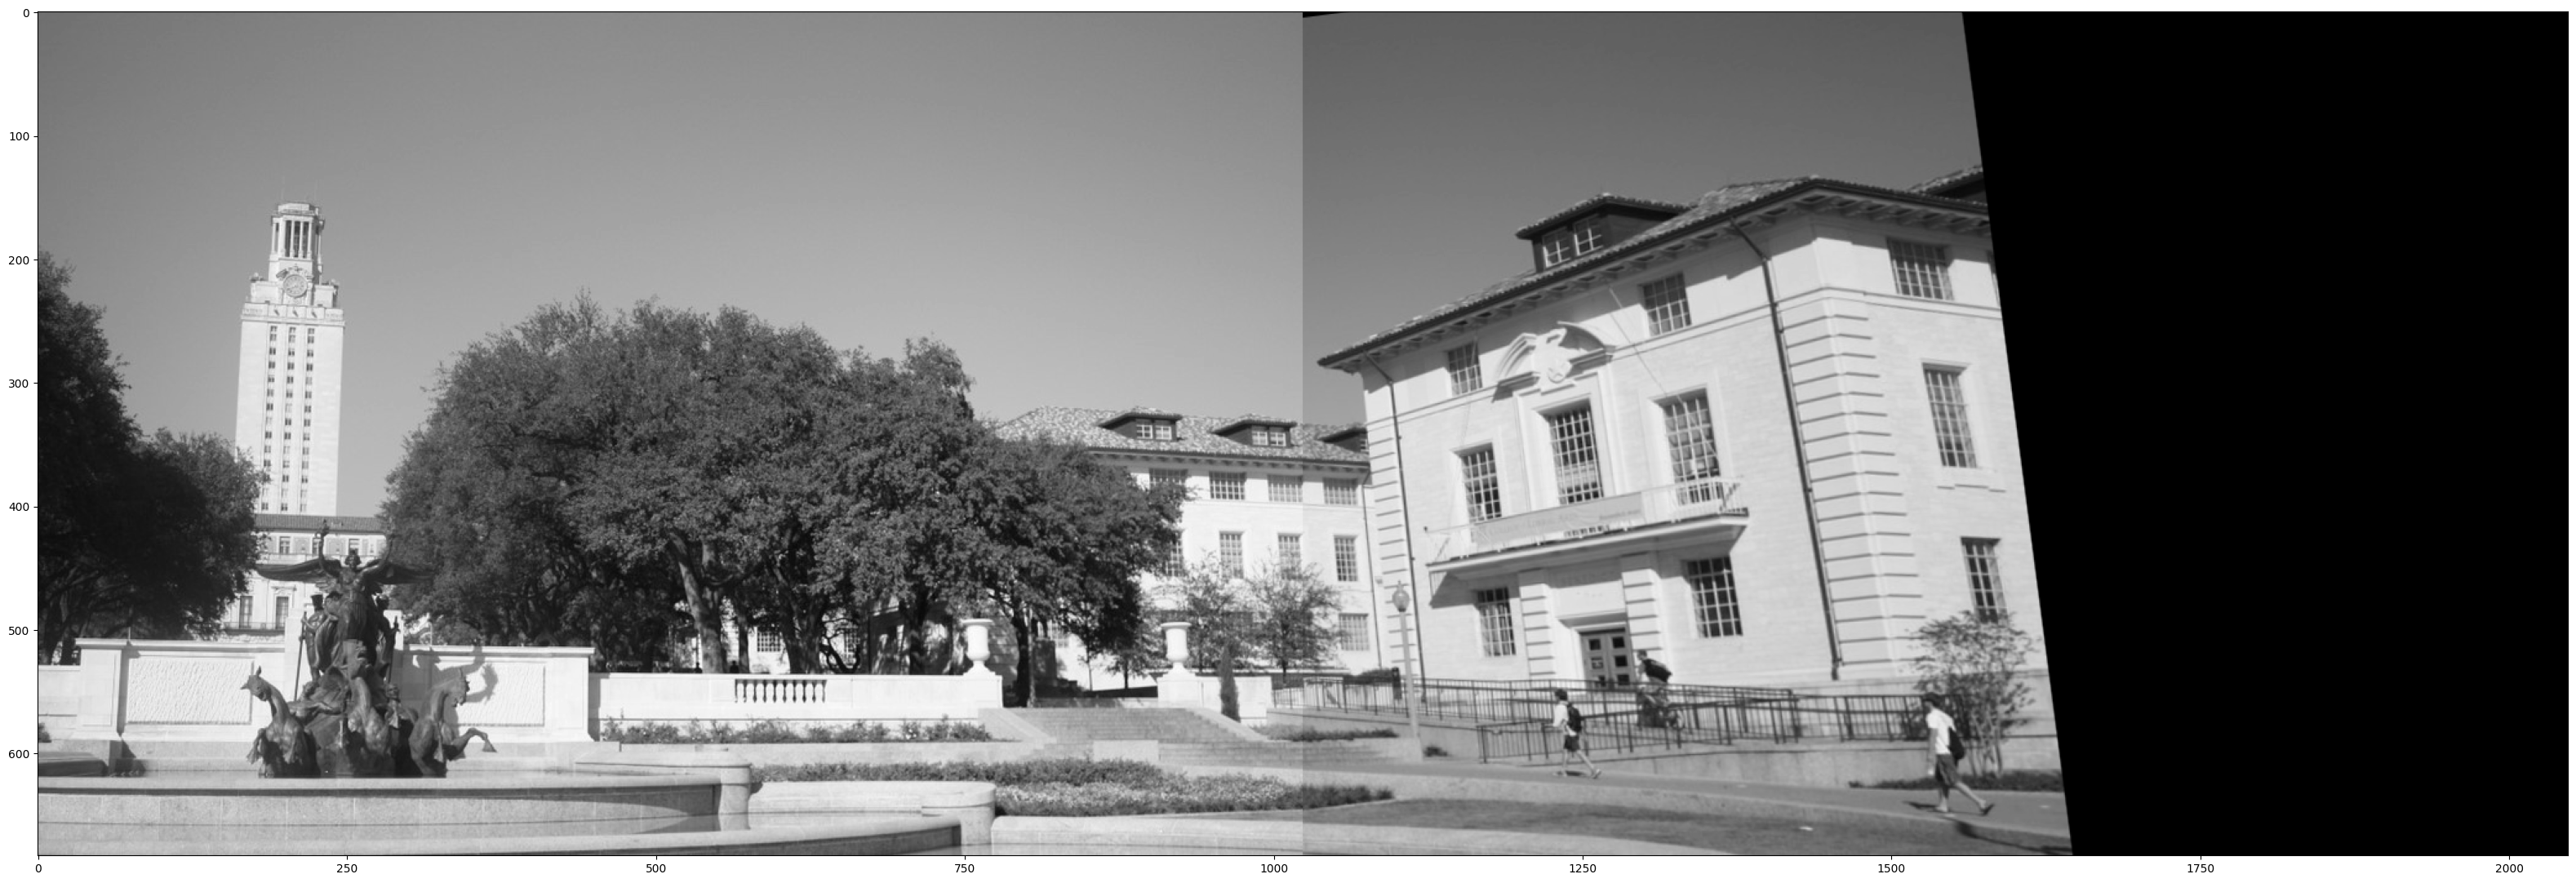

In [19]:
plt.figure(figsize=(40,20)),plt.imshow(result,cmap='gray')

**Bonus**: try other descriptors than the SIFT ones. Try to implement your own.

**Bonus:** try to correct the change of luminosity between the two images so that the panorama look more realistic.